# Importing necessary pacakges

In [ ]:
# import the necessary packages
import numpy as np
from urllib.request import urlopen
import cv2
from matplotlib import pyplot as plt

# Utility functions

In [ ]:
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
	return image

In [ ]:
"""
    image: 3 channel image
"""
def compute_max_flat_image(image):
    return np.fmax( np.fmax( image[:,:,0], image[:,:,1] ), image[:,:,2] )

"""
Input:
    image: 3 channel image
"""
def compute_normalized_flat_image(image):
    flattened = image[:,:,0]
    flattened += image[:,:,1]
    flattened += image[:,:,2]    
    
    #Scale the image to 0-255
    min_value = flattened.min()
    max_value = flattened.max()
    
    flattened == (flattened-min_value)*(255/max_value)
    return flattened

"""
Input:
    original_image - 3 channel image
    filtered_image - 3 channel image

Assumptions: Images are of the same dimensions
"""
def compute_comparison_image(original_image, filtered_image):
    filter_flattened = compute_max_flat_image(filtered_image)
    
    filtered_image_3layers = np.zeros(filtered_image.shape)
    filtered_image_3layers[:,:,0] = filter_flattened
    filtered_image_3layers[:,:,1] = filter_flattened
    filtered_image_3layers[:,:,2] = filter_flattened        
    
    merged_image = np.concatenate( [original_image, filtered_image_3layers ] , axis = 1)
    return merged_image

# Downloading a sample image to work with

In [ ]:
image = url_to_image("https://fontsarena-cd5e.kxcdn.com/wp-content/uploads/2019/04/helvetica-now-font-400x364.png")
diagonal_image = url_to_image("https://img.discogs.com/gYM-wlxC7ycGp-ZUQK9o_oCm0OE=/fit-in/500x500/filters:strip_icc():format(jpeg):mode_rgb():quality(90)/discogs-images/L-305246-1399376525-6025.jpeg.jpg")
image = cv2.resize(image,(400, int(image.shape[0]*(400/image.shape[1]))  ) )
diagonal_image = cv2.resize(diagonal_image,(400, int(diagonal_image.shape[0]*(400/diagonal_image.shape[1]))  ) )

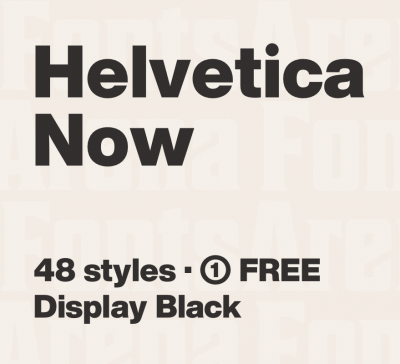

In [5]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

# Canny Edge detector

In [ ]:
edges = cv2.Canny(image,100,200)

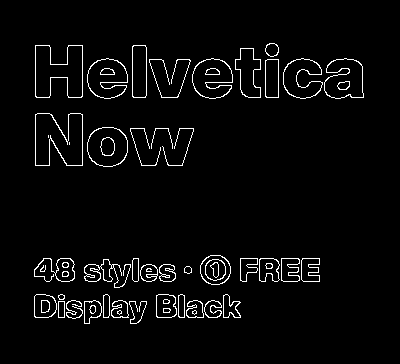

In [7]:
cv2_imshow(edges)

# Vertical edge detector

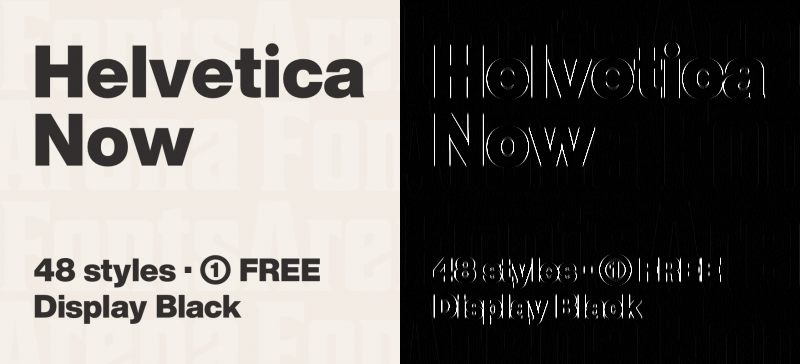

In [8]:
vertical_edge_kernel = np.float32([
    [-1, 2,-1],
    [-1, 2,-1],
    [-1, 2,-1]
])

vertical_edges = cv2.filter2D(image,-1,vertical_edge_kernel)
cv2_imshow( compute_comparison_image(image, vertical_edges))

The vertical edge detector given in the notebook for the excercise was:

1,0,-1
<br>1,0,-1
<br>1,0,-1

The above isnt symmteric along the vertical axis, and would differentiate between two images, one where white is on the left of the line and the other where white is on the right of the line.

The filter

-1,2,-1
-1,2,-1
-1,2,-1

on the other hand is symmetric and would produce the same output no matter how the gradient of values across the edge is. Another alternative to having a symmetric kernel is to take absolute values of the convolved image and the rescale it values 0-255.

There is some thought process behind why the elements in the middle column are 2 and not some other scalar. 2 ensures that the max value doesnt change ( i.e the max value possible is still 255 ( assuming a 0-225 representation ) ). Using higher values leads to most of the image becoming white, unless the image is rescaled to 0-255

# Horizontal edge detector

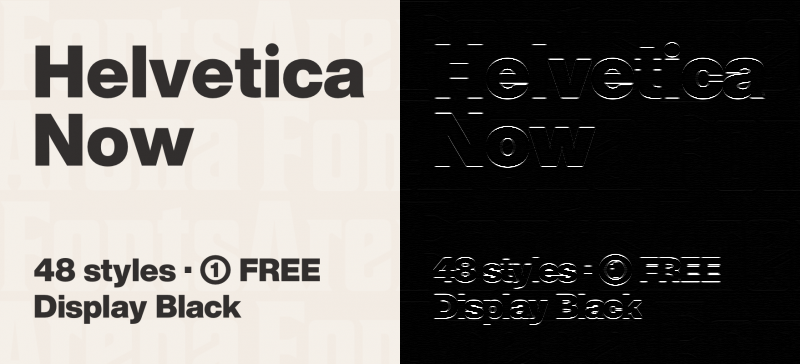

In [9]:
horizontal_edge_kernel = np.float32([
    [-1,-1,-1],
    [ 2, 2, 2],
    [-1,-1,-1]
])
horizontal_edges = cv2.filter2D(image,-1,horizontal_edge_kernel)
cv2_imshow( compute_comparison_image(image, horizontal_edges) )

The horizontal edge detector is essentially a transpose of the vertical edge detector

## Comparison with the canny edge detector

If we combined our horizontal and vertical edge detectors, how do they compare to the canny edge detector?

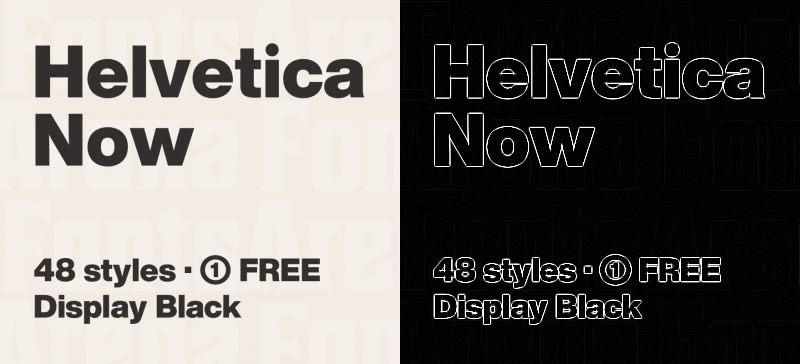

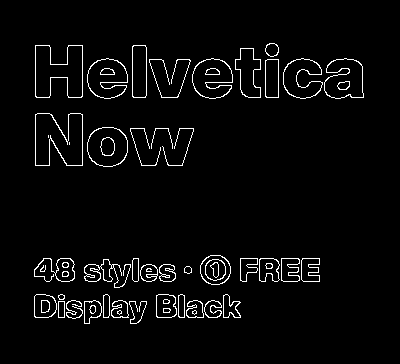

In [10]:
cv2_imshow( compute_comparison_image( image, np.fmax(horizontal_edges,vertical_edges)  ) )
cv2_imshow(edges)

That pretty close. The canny edge detector is pretty complex and not as simple as detecting horizontal and verical edges. Hence we cant expect the same output.

# 45 Degree angle edge detector

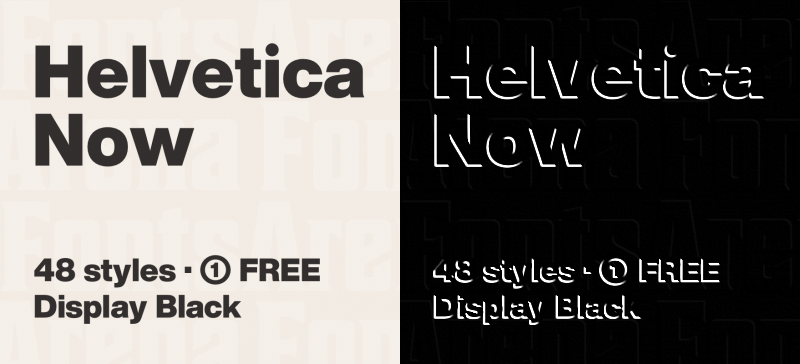

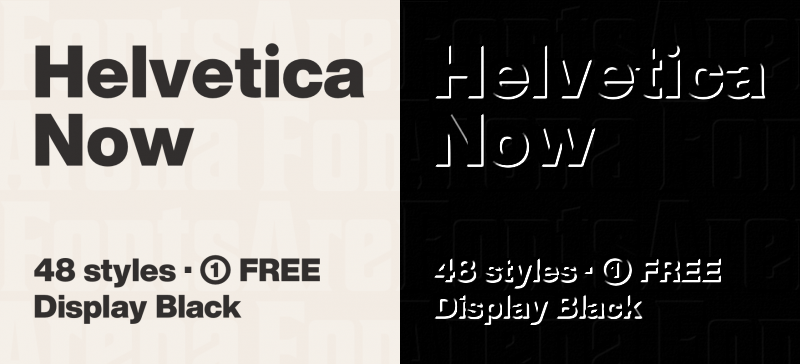

In [11]:
slanting_edge_kernel = np.float32([
    [0, -1,-1],
    [1 ,0, -1],
    [1, 1, 0]
])
slanting_edge_kernel_2 = cv2.flip(slanting_edge_kernel,1)
slanting_edges = cv2.filter2D(image,-1, slanting_edge_kernel) # detecting edges going from bottom right to top left
slanting_edges_2 = cv2.filter2D(image,-1, slanting_edge_kernel_2) # detecting edges going from bottom left to top right
cv2_imshow( compute_comparison_image( image, slanting_edges ) )
cv2_imshow( compute_comparison_image( image, slanting_edges_2 ) )

Firstly there are 2 kernels above. The first ( slanting_edge_kernel ) detects edge that go from top left to bottom right. The second ( slanting_edge_kernel_2 ) detects edges that go from top right to bottom left.

In the above image if one must carefully observe the v's and the y's. In these character's one can clearly see the difference in how the kernel detects slanting lines in either orientation. One kernel detects line slanting left to right and the other kernel detects lines slanting right to left.

There is a limitation with this kernel though, its not symmetric. Because the kernel is not symmetric, it distinguishes transitions on the 45 degree edge. Meaning the output for the following two images would be different.

![white above diagonal](https://lh3.googleusercontent.com/guUma09nlnJgTfk8EErb1FwrQUsZLE2guPJALZoO88Wn6ZnWx-TkzEF1pRrYhnDpfdfX5mCylPPfiF8ZNQdfDFIDuH_GIwGzqXCe)

![white below diagonal](https://lh3.googleusercontent.com/om1rnoCMDjxGuRwdToYjP0h0RdVGZlkNFb94puLs7H1ccCNfuzFX0uHyCXBQVeuq5NrkzvBBJPW_v1_7tEUYmCjFWq6bY9AZyYc_)

This is sub optimal and certainly not desirable. In fact one can that the edges of purely vertical and horizontal edges are handled differently in the 2 kernels. 
I was unable to find a symmetric diagonal edge detection kernel. I tried a couple more options but wasnt able to find anything. If made made all elements away from the diagonal negative then it got pretty close to a sharpen kernel and didnt work as expected.

The effect of the 45 degree slop detector is best seen in the following image

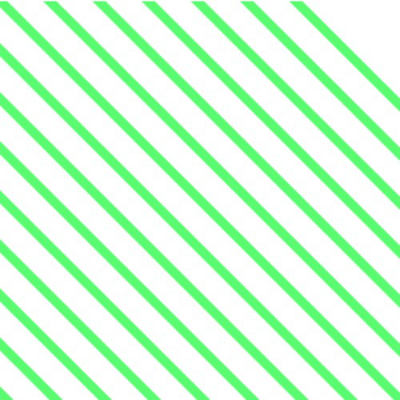

In [12]:
cv2_imshow(diagonal_image)

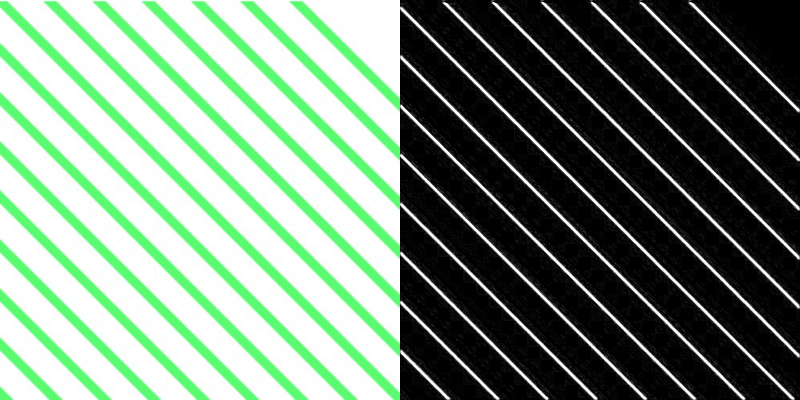

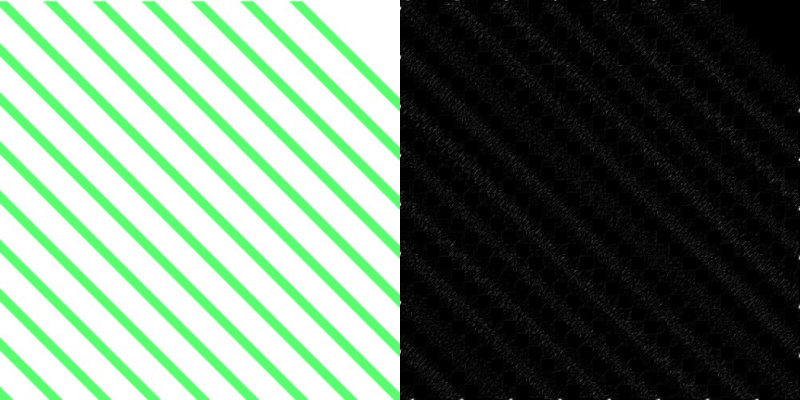

In [13]:
cv2_imshow( compute_comparison_image( diagonal_image, cv2.filter2D(diagonal_image,-1, slanting_edge_kernel) ) )
cv2_imshow( compute_comparison_image( diagonal_image, cv2.filter2D(diagonal_image,-1, slanting_edge_kernel_2) ) )

We apply both the 45 degree slope filters on the diagonal lines image. We clearly see that the filter doesnt pick up lines along its corresponding perpendicular diagonal

# Blur kernel

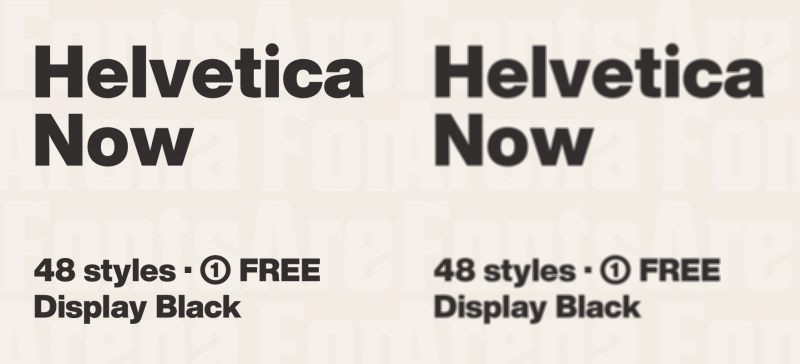

In [14]:
blur_kernel = np.float32([
    [1,1,1],
    [1,0,1],
    [1,1,1]
])/8

blurred_image = cv2.filter2D(image,-1,blur_kernel)
cv2_imshow(np.concatenate([image, blurred_image], axis =1))

Blurring here is achieved by making each pixel the average of all its neighbouring 8 pixels. The dividing by 8 ensures that the scale of the image doesnt change and that the image doesnt need further rescaling.

While this kernel does blur, the blur radius is limited to the immediate neighbouring pixels with a 3x3 kernel. For a larger blur radius, one needs a larger kernel size.

# Sharpen kernel

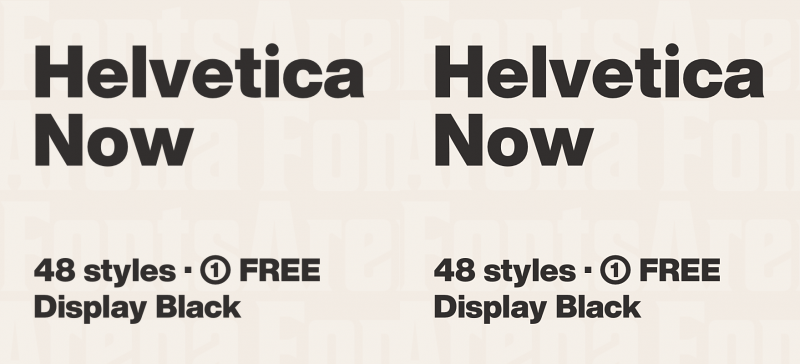

In [15]:
sharpen_kernel = np.float32([
    [-1,-1,-1],
    [-1,50,-1],
    [-1,-1,-1]
])/42

sharpened_image = cv2.filter2D(image,-1,sharpen_kernel)
cv2_imshow(np.concatenate([image, sharpened_image], axis =1))

Sharpening is the opposite of blurring in a way. Here we want to remove the effect of the neighbouring pixels from a given pixel, and that removal is represented by all the negative ones for non center points. The value of the center point decides the coarseness/smootheness of the filter. As its value increases, the result of the convolution tends to the value of the center pixel and the extent to which the neighouring pixels are subtracted decreases. After experimenting with a few values, 50 seemed to give a good looking result, hence picked that.

The filter is divided by the sum of all its elements to ensure the max value doesnt cross 255 ( or as appropriate ). For the centre value 50 its 50 - 8 = 42

# Identity kernel

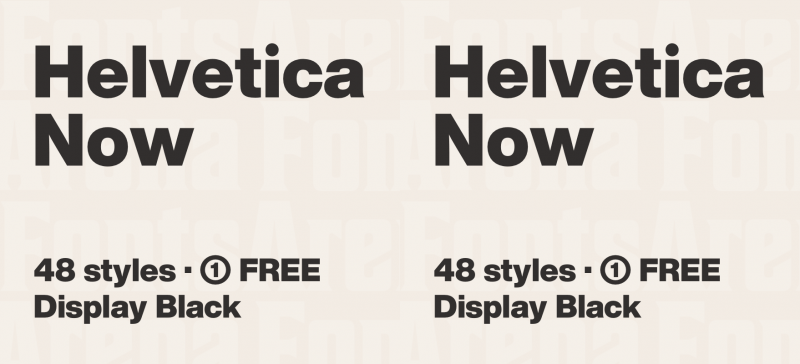

In [16]:
identity_kernel = np.float32([
    [0,0,0],
    [0,1,0],
    [0,0,0]
])

identity_image = cv2.filter2D(image,-1,identity_kernel)
cv2_imshow(np.concatenate([image, identity_image], axis =1))

In [17]:
# Is the resulting image truly identical
np.all( identity_image == image )

True

Here we want to only consider the centre pixel in a convolution and not consider any effects from neighbouring pixels. This is represented by making the center value of the kernel 1 and keeping the rest 0.

What seems interesting is what happens at the edges of the image. I know OpenCV does some interpolation. What surprises me is that despite the interpolation, we have an exactly equality between the convolved image and the original image as demonstrated above